# Load packages and probabilities from models

In [78]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

#load necessary data

df_notes_death = pd.read_csv('notes_with_survival_probability.csv')
df_notes_death = df_notes_death[['Death_Text', 'icu_death']]
df_TCN_death = pd.read_csv('tcn_probs_of_death_traintest.csv')
df_TCN_death = df_TCN_death.rename(columns={"probs": "TCN_death"})
df_LSTM_death = pd.read_csv('lstm_probs_of_death_traintest.csv')
df_LSTM_death = df_LSTM_death.rename(columns={"predictions": "LSTM_death"})
df_XGB_death = pd.read_csv('XGB_probs_of_death_traintest.csv')
df_XGB_death = df_XGB_death.rename(columns={"probs": "XGB_death"})
df_RF_death = pd.read_csv('RF_probs_of_death_traintest.csv')
df_RF_death = df_RF_death.rename(columns={"probs": "RF_death"})


df_combined = pd.concat([df_notes_death, df_TCN_death, df_LSTM_death, df_XGB_death, df_RF_death],join='outer', axis=1)
df_combined

,Death_Text,icu_death,TCN_death,LSTM_death,XGB_death,RF_death
0,0.667203,1,0.817608,0.807164,0.936458,0.530172
1,0.677843,0,0.002271,0.000504,0.908735,0.522452
2,0.328213,0,0.000002,0.003370,0.912528,0.537038
3,0.285082,0,0.895399,0.597768,0.995528,0.612666
4,0.115619,0,0.000003,0.019284,0.970156,0.575646
...,...,...,...,...,...,...
16317,0.185437,0,0.226945,0.300671,0.892765,0.509793
16318,0.614558,0,0.013307,0.402822,0.892765,0.514793
16319,0.005906,0,0.000241,0.000409,0.998102,0.594447
16320,0.108837,0,0.023082,0.540763,0.892765,0.517190


In [79]:
def plot_roc_curve(models, Xtest, ytest):
    plt.figure(figsize=(10,8))
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
#         # for neural network
#         else:
#             model.eval()
#             Xtest_tensor = torch.FloatTensor(Xtest)
#             with torch.no_grad():
#                 outputs = model(Xtest_tensor)
#                 ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()
    
def eval_metrics(models, Xtest, ytest):
    res_df = []
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
            ypred = model.predict(Xtest)
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
            ypred = model.predict(Xtest)
#         # for neural network
#         else:
#             model.eval()
#             with torch.no_grad():
#                 Xtest_tensor = torch.FloatTensor(Xtest)
#                 outputs = model(Xtest_tensor)
#                 ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function
#                 ypred = (ypred_proba >= 0.5).astype(int)

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)
        precision = precision_score(ytest, ypred, average='macro', zero_division=0)
        recall = recall_score(ytest, ypred, average='macro', zero_division=0)
        f1 = f1_score(ytest, ypred, average='macro', zero_division=0)

        result = pd.DataFrame({'AUROC':roc_auc,
                               'Precision':precision,
                               'Recall':recall,
                               'F1 Score':f1}, index=[model_name])
        res_df.append(result)
    
    final_df = pd.concat(res_df)
    return final_df

# Test various classifiers and stacking for death classification

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

y_death = df_combined['icu_death']

#comment out as required before running model
X_death = df_combined[["Death_Text",
#         "TCN_death",
#        "LSTM_death",
#        "XGB_death",
        "RF_death"
       ]]


X_death_train, X_death_test, y_death_train, y_death_test = train_test_split(X_death, y_death, test_size=0.2, stratify=y_death, shuffle=True, random_state=42)

logR_death = LogisticRegression(random_state=42)
logR_death.fit(X_death_train, y_death_train)

GNB_death = GaussianNB()
GNB_death.fit(X_death_train, y_death_train)

RF_death = RandomForestClassifier(random_state=42)
RF_death.fit(X_death_train, y_death_train)

DecisionTree_death = DecisionTreeClassifier(random_state=42)
DecisionTree_death.fit(X_death_train, y_death_train)

estimators = []
estimators.append(('Logistic Regression Classifier', LogisticRegression(random_state=42) ))
estimators.append(('Gaussian Naive Bayes Classifier', GaussianNB() ))
estimators.append(('Random Forest Classifier', RandomForestClassifier(random_state=42) ))
estimators.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42) ))

logisticR = LogisticRegression(random_state=42)

SC_death = StackingClassifier(estimators=estimators,
                        final_estimator=logisticR,
                        cv=6,
                        #stack_method='predict_proba'
                       )
SC_death.fit(X_death_train, y_death_train)


StackingClassifier(cv=6,
                   estimators=[('Logistic Regression Classifier',
                                LogisticRegression(random_state=42)),
                               ('Gaussian Naive Bayes Classifier',
                                GaussianNB()),
                               ('Random Forest Classifier',
                                RandomForestClassifier(random_state=42)),
                               ('Decision Tree Classifier',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

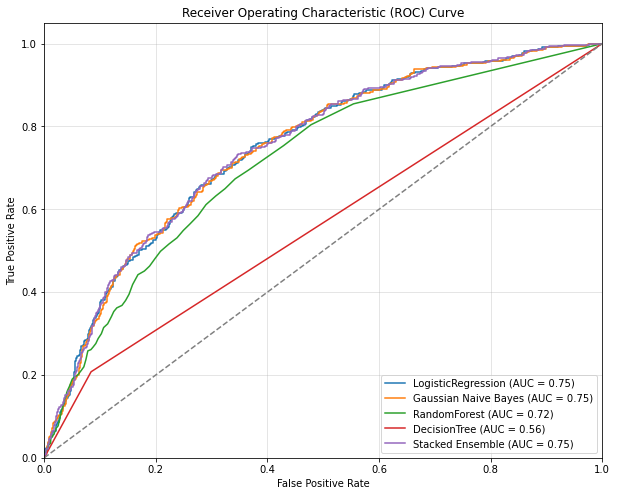

,AUROC,Precision,Recall,F1 Score
LogisticRegression,0.747638,0.629383,0.510621,0.496976
Gaussian Naive Bayes,0.747105,0.573663,0.502914,0.480850
RandomForest,0.715138,0.595399,0.537072,0.544215
DecisionTree,0.561849,0.565490,0.561849,0.563553
Stacked Ensemble,0.748872,0.620053,0.523014,0.521486


In [82]:
models_death = {'LogisticRegression':logR_death,
          'Gaussian Naive Bayes':GNB_death,
          'RandomForest':RF_death,
         'DecisionTree':DecisionTree_death,
         'Stacked Ensemble':SC_death}

# check model performance
plot_roc_curve(models_death, X_death_test, y_death_test)
eval_metrics(models_death, X_death_test, y_death_test)

# Best death predictor is Text_RF with logR, export model

In [83]:
import pickle

with open('ensb_logreg_death.pkl', 'wb') as file:
    pickle.dump(logR_death, file)